In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

In [3]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
he = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')

## Avg Sales by date

In [4]:
train_avg = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_avg = train_avg.reset_index()
train_avg

,date,sales,onpromotion
0,2013-01-01,1.409438,0.000000
1,2013-01-02,278.390807,0.000000
2,2013-01-03,202.840197,0.000000
3,2013-01-04,198.911154,0.000000
4,2013-01-05,267.873244,0.000000
...,...,...,...
1679,2017-08-11,463.733851,7.956790
1680,2017-08-12,444.798280,4.664422
1681,2017-08-13,485.768618,5.209315
1682,2017-08-14,427.004717,4.513468


In [5]:
train_avg['date'] = pd.to_datetime(train_avg['date'])
train_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1684 non-null   datetime64[ns]
 1   sales        1684 non-null   float64       
 2   onpromotion  1684 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 39.6 KB


In [6]:
from statsmodels.nonparametric.smoothers_lowess import lowess
df_loess_3 = pd.DataFrame(lowess(train_avg.sales, np.arange(len(train_avg.sales)), frac=0.03)[:, 1], index=train_avg.index, columns=['sales'])
df_loess_5 = pd.DataFrame(lowess(train_avg.sales, np.arange(len(train_avg.sales)), frac=0.05)[:, 1], index=train_avg.index, columns=['sales'])

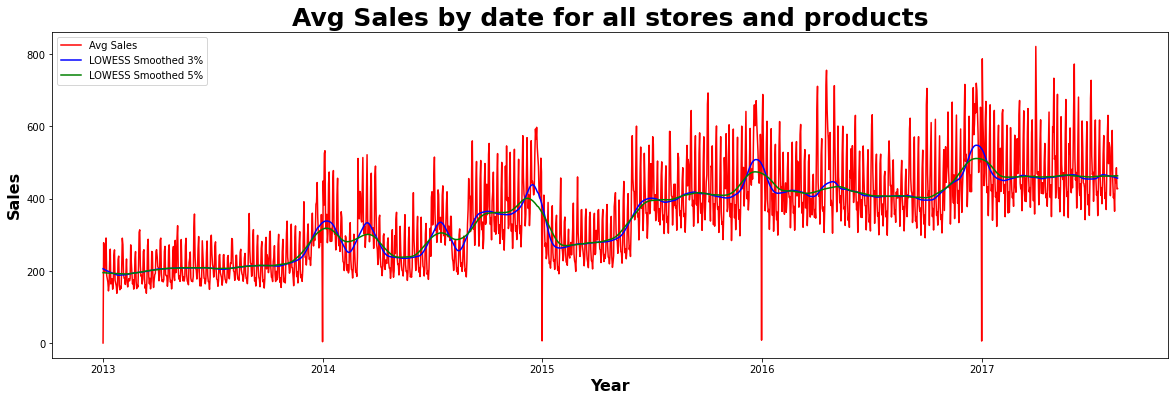

In [77]:
plt.figure(figsize = (20,6))
plt.plot(train_avg['date'], train_avg['sales'], color = 'red')
plt.plot(train_avg['date'],df_loess_3['sales'], color = 'blue')
plt.plot(train_avg['date'],df_loess_5['sales'], color = 'green')
plt.legend(['Avg Sales','LOWESS Smoothed 3%','LOWESS Smoothed 5%'])
plt.xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.title('Avg Sales by date for all stores and products', fontsize=25, fontdict=dict(weight='bold'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) #設定x軸主刻度間距

plt.savefig('fig/Avg Sales by date for all stores and products.png')

In [7]:
train_avg[(train_avg['date'] =='2013-01-01' )|(train_avg['date'] =='2014-01-01' )|( train_avg['date'] =='2015-01-01')|(train_avg['date'] =='2016-01-01')|(train_avg['date'] =='2017-01-01')]

,date,sales,onpromotion
0,2013-01-01,1.409438,0.000000
364,2014-01-01,4.827197,0.000000
728,2015-01-01,7.168135,0.006734
1092,2016-01-01,9.221882,0.089226
1457,2017-01-01,6.780304,0.095398


## Seasonal Plot

In [8]:
def date_form(df):
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

date_form(train)
date_form(oil)
date_form(he)

In [9]:
def grouped(df,key,freq,col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def add_time(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [10]:
df_grouped_train_w = add_time(train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(train, 'date', 'M', 'sales')

In [7]:
train_avg['year'] = [d.year for d in train_avg.date]
train_avg['month'] = [d.strftime('%b') for d in train_avg.date]
years = train_avg['year'].unique()
train_avg_m = train_avg[['date', 'sales', 'year','month']].groupby(['year','month'], sort = False).mean()
train_avg_m = train_avg_m.reset_index()

In [8]:
import matplotlib as mpl
np.random.seed(2022)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

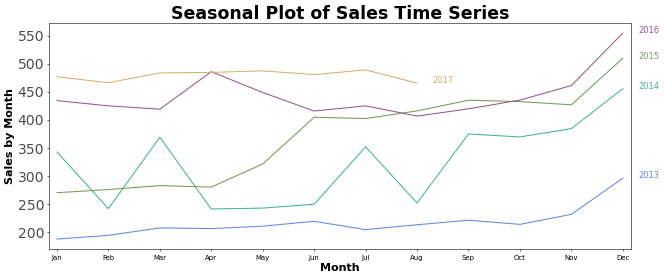

In [15]:
plt.figure(figsize=(15,6), dpi= 50)
for i, y in enumerate(years):
    if i >= 0:        
        plt.plot('month', 'sales', data=train_avg_m.loc[train_avg_m.year==y, :], color=mycolors[i], label=y)
        plt.text(train_avg_m.loc[train_avg_m.year==y, :].shape[0]-.7, train_avg_m.loc[train_avg_m.year==y, 'sales'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(-0.15, 11.15))
plt.xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Month', fontsize = 16, fontdict=dict(weight='bold'))
plt.yticks(fontsize=20, alpha=.7)
plt.title("Seasonal Plot of Sales Time Series", fontsize=25, fontdict=dict(weight='bold'))
plt.savefig('fig/Seasonal Plot.png')
plt.show()

## year-wise box plot

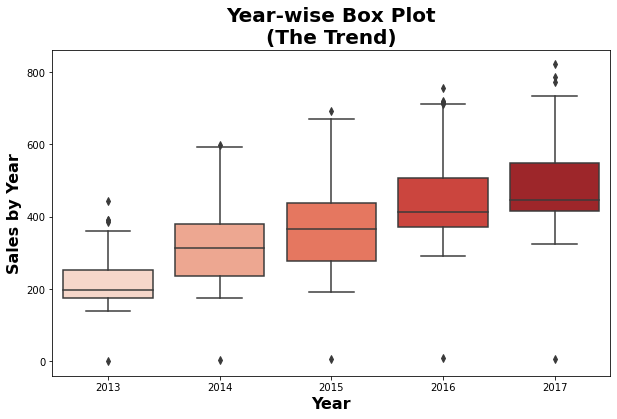

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.boxplot(x = 'year', y = 'sales', data = train_avg, palette="Reds")
plt.title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.savefig('fig/Year-wise Box Plot.png')


<AxesSubplot:title={'center':'sales'}, xlabel='[year]'>

<Figure size 720x432 with 0 Axes>

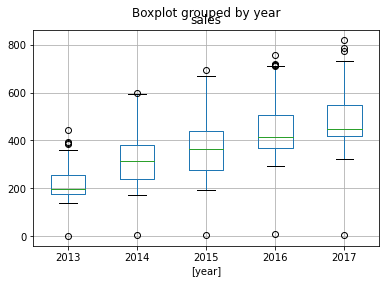

In [32]:
plt.figure(figsize=(10, 6))
test = train_avg[['date','sales','year']]
test.boxplot(by = 'year')

## month-wise box plot

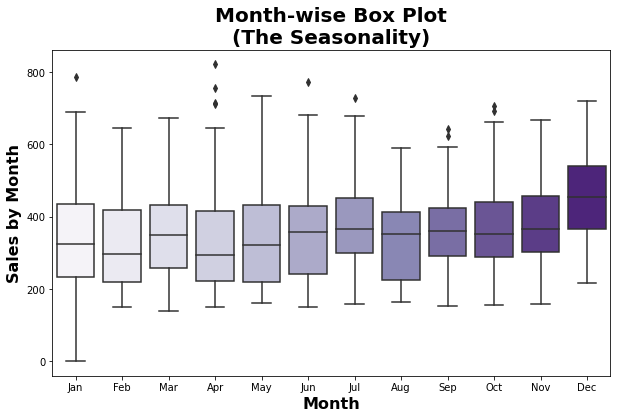

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'month', y = 'sales', data = train_avg, palette="Purples")
plt.title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Month', fontsize = 16, fontdict=dict(weight='bold'))
plt.savefig('fig/Month-wise Box Plot.png')

# oil

In [37]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [9]:
oil.loc[oil['date'] == '2013-01-01', 'dcoilwtico'] = 93.14
oil = oil.interpolate(method='linear', limit=20) #fill

In [10]:
oil['date'] = pd.to_datetime(oil['date'])
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


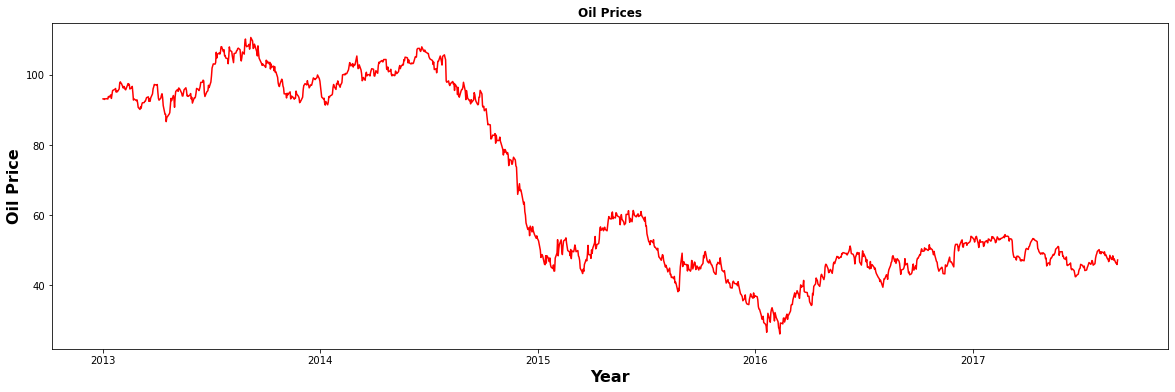

In [47]:
plt.figure(figsize = (20,6))
plt.plot(oil['date'], oil['dcoilwtico'], color = 'red')
plt.xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Oil Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.title('Oil Prices', fontdict=dict(weight='bold'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) #設定x軸主刻度間距

plt.savefig('fig/Oil Prices.png')

In [64]:
sales_oil = pd.merge(train_avg, oil, on = 'date')
overall_pearson_r = sales_oil.corr().iloc[0,3]
print(f"Pearson r: {overall_pearson_r}")

Pearson r: -0.6901445257663238


# Top Family Products by Avg Sales

In [11]:
df_family = train[['family', 'sales']].groupby('family').mean().sort_values('sales', ascending=True)
df_family = df_family.reset_index()
df_family_10 = df_family[-10:]

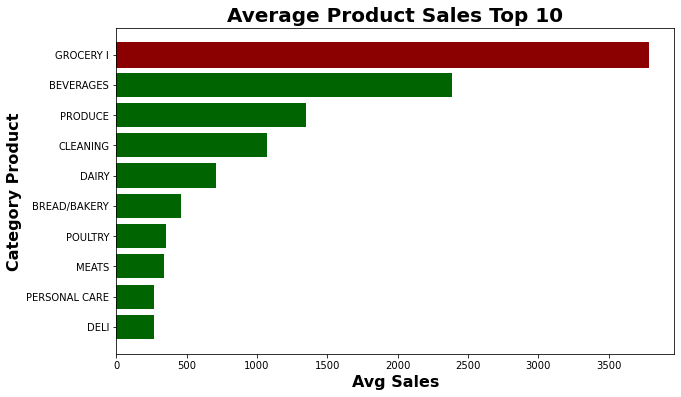

In [79]:
plt.figure(figsize=(10, 6))
barplot = plt.barh(df_family_10['family'], df_family_10['sales'], color = 'darkgreen')
barplot[9].set_color('darkred')
plt.title('Average Product Sales Top 10', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Avg Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Category Product', fontsize = 16, fontdict=dict(weight='bold'))
plt.savefig('fig/Average Product Sales Top 10.png')
plt.show()

# seasonal_plot_2

In [52]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize = (20,6))
    palette = sns.color_palette("tab10", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [69]:
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.day_name()
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

avg_sales = train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()


,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


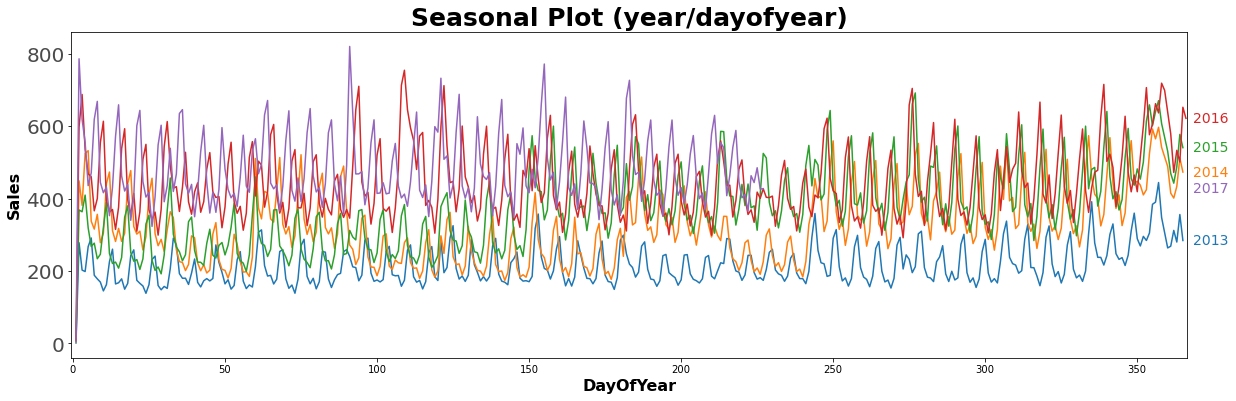

In [73]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import seaborn as sns

X = avg_sales.copy()

# days within a week
# X['day'] = X.index.dayofweek # the x-axis (freq)
# X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(18, 10))
# seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)

seasonal_plot(X, y="sales", period="year", freq="dayofyear")
plt.gca().set(xlim=(-0.5, 366.5))
plt.xlabel('DayOfYear', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.yticks(fontsize=20, alpha=.7)
plt.title("Seasonal Plot (year/dayofyear)", fontsize=25, fontdict=dict(weight='bold'))
plt.savefig('fig/Seasonal Plot_2.png')


In [44]:
X[X['week']==53]

,sales,day,week,dayofyear,year
date,,,,,
2015-12-28,443.145293,0,53,362,2015
2015-12-29,488.643112,1,53,363,2015
2015-12-30,578.026788,2,53,364,2015
2015-12-31,541.325220,3,53,365,2015
2016-01-01,9.221882,4,53,1,2016
2016-01-02,598.584414,5,53,2,2016
2016-01-03,688.403883,6,53,3,2016


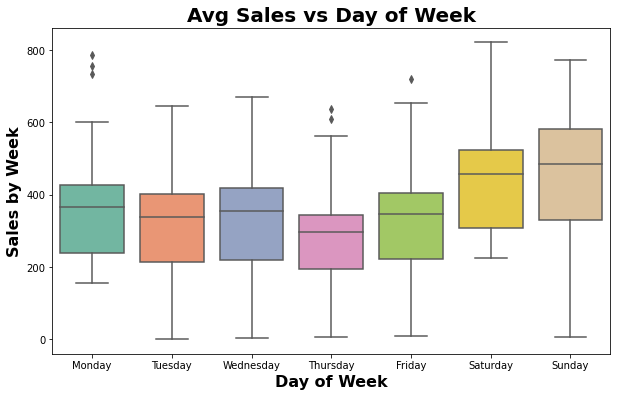

In [109]:
train_avg['dayofweek'] = train_avg['date'].dt.day_name()

fig = plt.figure(figsize=(10, 6))
sns.boxplot(x = 'dayofweek', y = 'sales', data = train_avg, palette="Set2",
            order=['Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday','Sunday'])
plt.title('Avg Sales vs Day of Week', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Day of Week', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Week', fontsize = 16, fontdict=dict(weight='bold'))
plt.savefig('fig/Week-wise Box Plot.png')